In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.simplefilter('ignore')

## Предобработка данных.

Этот ноутбук посвящён предобработке данных акций четырёх компаний, выбранных нами для анализа:
* **FIVE** - X5 Retail Group (торги на Мосбирже начались с 1 февраля 2018 года). 
* **MGNT** - Магнит, начал торговаться до 2014 года.
* **LNTA** - Лента, начал торговаться до 2014 года.
* **MVID** - М.Видео, начал торговаться до 2014 года. Акции неликвидны, и потому мы ожидаем наиболее высокой волатильности для этого эмитента.

Поскольку традиционная практика в финансовой эконометрике - анализ доходностей инструментов, а не исходных рядов (зачастую это позволяет сходу решить проблему нестационарности исходного ряда, кроме того, рассмотрение доходностей имеет больший смысл с точки зрения практических целей моделирования), то далее всюду будут подразумеваться не исходные ряды, а доходности, если не оговорено иное.

**Основные задачи:**

0. Посмотреть длину рядов.
1. Сравнить доходность акций за рассматриваемый период.
2. Визуально изучить распределения доходностей акций.
3. Посчитать выборочные характеристики всех четырёх акций: среднее, дисперсию, стандартное отклонение, куртозис и эксцесс.
4. Провести тест Дики-Фуллера для проверки стационарности рядов.
5. Построить выборочные ACF и PACF, которые помогут нам выбрать модель среднего для одномерных моделей доходностей.
6. Построить выборочные ACF и PACF для квадратов доходностей (если их среднее окажется близким к нулю), которые помогут нам протестировать визуально ряды на наличие условной гетероскедастичности. Как показывает практика, выбор конкретного порядка именно для GARCH-модели не так важен, [поскольку уже GARCH(1,1), как правило, достаточно хорошо описывает условную гетероскедастичность в данных](https://www.jstor.org/stable/25146403?seq=1).
7. Построить корреляционную матрицу.

In [5]:
p = pd.DataFrame(pd.read_csv(
    'https://raw.githubusercontent.com/palantir-py/metrics_HW2/main/data/daily_prices.csv', 
     parse_dates=True, index_col=0))
p.head(5)

,MGNT,LNTA,MVID,FIVE
TRADEDATE,,,,
2014-09-01,8900.0,425.00,188.99,NaN
2014-09-02,9010.0,430.00,183.50,NaN
2014-09-03,9409.2,440.99,198.71,NaN
2014-09-04,9508.0,434.98,195.97,NaN
2014-09-05,9750.0,438.99,199.23,NaN


In [6]:
p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1671 entries, 2014-09-01 to 2021-04-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MGNT    1671 non-null   float64
 1   LNTA    1671 non-null   float64
 2   MVID    1671 non-null   float64
 3   FIVE    811 non-null    float64
dtypes: float64(4)
memory usage: 65.3 KB


Мы видим, что для X5 примерно в два раза меньше значений, чем для всех остальных акций. Но мы не можем удалить её из анализа, так как это крупнейшая розничная сеть по торговле продуктами в России, а Лента и Магнит - два других члена тройки лидеров.
Теперь посчитаем и сохраним данные по доходностям акций:

In [7]:
import os
fpath = (os.getcwd()+'/data/returns.csv').replace('\\', '/').replace('/scripts', '')
print(f'Файл будет сохранён по адресу: /n {fpath}')
r = p.pct_change()['2014-09-02':]
r.to_csv(fpath)

Файл будет сохранён по адресу: /n C:/Users/Vladimir/Desktop/FMFI_1/Магистерские курсы/Эконометрика/HW2/metrics_HW2/data/returns.csv


In [8]:
r.head(4)

,MGNT,LNTA,MVID,FIVE
TRADEDATE,,,,
2014-09-02,0.012360,0.011765,-0.029049,NaN
2014-09-03,0.044306,0.025558,0.082888,NaN
2014-09-04,0.010500,-0.013628,-0.013789,NaN
2014-09-05,0.025452,0.009219,0.016635,NaN


#### 1.  Сравним кумулятивную доходность акций, которые есть в выборке.
Без учёта X5 Retail Group:

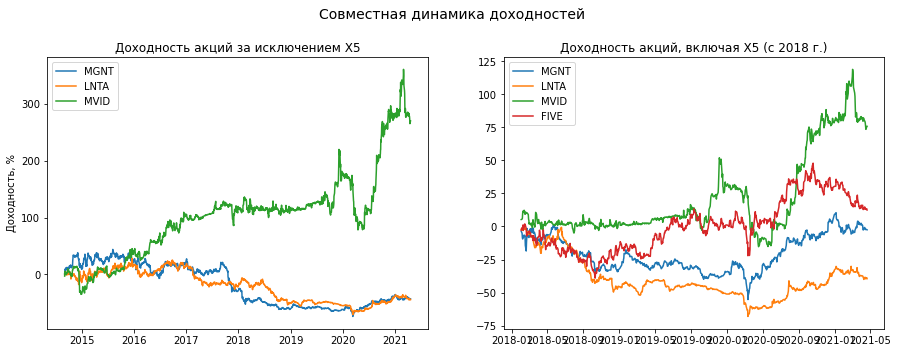

In [9]:
fpath = os.getcwd().replace('\\', '/').replace('/scripts', '/images/')+'/'
mask = (r.index>='2018-02-02')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for ticker in r.drop(columns=['FIVE']).columns.tolist():
    ax1.plot(r.index, 
             (np.cumprod(r[ticker].values+1)-1)*100, label=str(ticker))
ax1.legend()
ax1.set_title('Доходность акций за исключением X5')
ax1.set_ylabel('Доходность, %')

for ticker in r.columns.tolist():
    ax2.plot(r[mask].index, 
             (np.cumprod(r[mask][ticker].values+1)-1)*100, label=str(ticker))
ax2.legend()
ax2.set_title('Доходность акций, включая X5 (с 2018 г.)')

fig.suptitle('Совместная динамика доходностей', fontsize=14, y=1.02)
plt.savefig(fpath+'Return dinamics.jpg', dpi=1200, bbox_inches='tight');
fig.show();

Действительно, наши ожидания сбылись. Мы можем отметить две особенности, исходя из графиков:
1. Динамика акций ПАО "Магнит", "Лента" и "X5 Retail Group" действительно взаимосвязана, при этом с середины 2019 года "X5 Retail Group" существенно опережает аналоги (это связано с фундаментальными причинами - компания стала безоговорочным лидером рынка ещё  раньше, но рынок с некоторым лагом учёл эту информацию в ценах).
2. Динамика акций М.Видео гораздо более волатильна и в значительно меньшей степени связана с движением трёх других эмитентов, хотя определённая взаимосвязь есть.

#### 2. Распределения доходностей акций.

Text(0.5, 1.08, 'Совместные распределения доходностей в зависимости от года')

Index(['MGNT', 'LNTA', 'MVID', 'FIVE'], dtype='object')

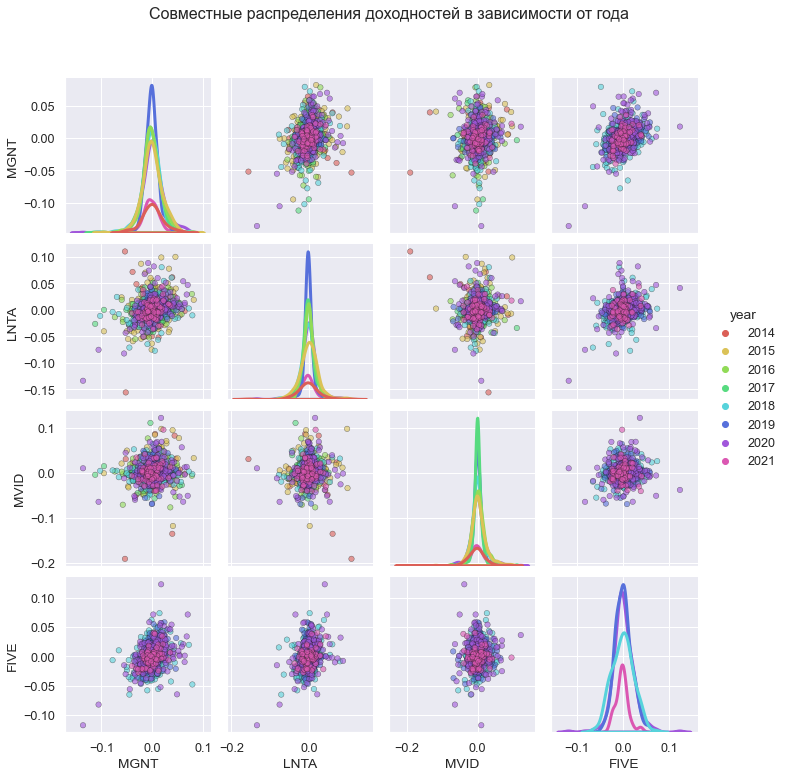

In [22]:
r['year'] = r.index.year

sns.set_style('whitegrid')
sns.set(font_scale=1.15)
#fig, ax = plt.subplots(figsize = (17,17))
ax = sns.pairplot(r, hue='year', diag_kind = 'kde', 
                 diag_kws= {'facecolor': 'None', 'linewidth':3},
                 plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
                 palette=sns.color_palette("hls", 8))
#plt.setp(ax.get_legend().get_texts(), fontsize='12');
#plt.setp(ax.get_legend().get_title(), fontsize='13');
ax.fig.suptitle('Совместные распределения доходностей в зависимости от года', fontsize=16, y=1.08);
#ax.fig.legend(title='Год', fontsize=15);
#g.set_title('Совместные распределения доходностей в зависимости от года', fontsize = 16, y =1.05);
plt.savefig(fpath+'pairplot - hue yearly.jpg', dpi=1200, bbox_inches='tight');

r.drop(columns=['year'], inplace=True)
r.columns

Исходя из графиков, можно отметить три особенности:
1. М.Видео наименее связан с остальными эмитентами.
2. Доходности имеют не-Гауссово распределение (возможно, распределены по Стьюденту). Об этом свидетельствует характерный куртозис выборочного распределения (рассмотрим на примере X5 Retail Group, акции, выборочное распределение которой наиболее близко к нормальному).
3. Год от года распределение доходностей значительно менялось.

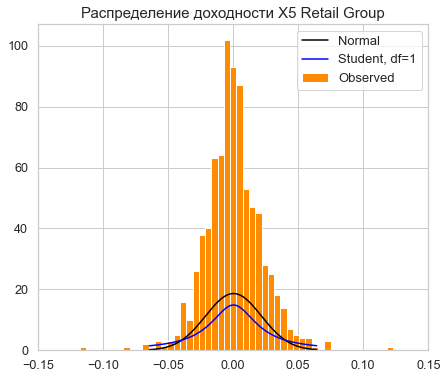

In [20]:
from scipy import stats
sns.set_style('whitegrid')

x = np.linspace(-3*r.FIVE.std(), 3*r.FIVE.std(), 1000)
fivenorm = stats.norm.pdf(x=x, loc=r.FIVE.mean(), scale=r.FIVE.std())
fivet = stats.t.pdf(x=x, df=1, loc=r.FIVE.mean(), scale=r.FIVE.std())

fig, ax = plt.subplots(figsize=(7, 6))
plt.hist(r.FIVE, bins=50, label='Observed', color='darkorange');
plt.plot(x, fivenorm, label='Normal', color='black');
plt.plot(x, fivet, label='Student, df=1', color='blue');
plt.xlim([-0.15, 0.15]);
plt.legend(fontsize=13);
plt.title('Распределение доходности X5 Retail Group', fontsize=15);
plt.savefig(fpath+'X5 distribution.jpg', dpi=1200, bbox_inches='tight');

Видно, что распределение Стьюдента лучше описывает данные с точки зрения разброса значения, но хуже, чем нормальное распределение, передаёт куртозис тех наблюдений, которые близки к выборочному среднему. Но в рамках моделирования волатильности и VaR нас куда больше интересуют выбросы и значения в "хвостах" распределения, чем среднее.

In [25]:
stats = pd.merge(r.agg([np.mean, np.median, np.std]).T,
                 pd.DataFrame({'kurtosis': r.kurtosis(axis=0),
                              'skewness': r.skew(axis=0)}), 
                left_index=True, 
                right_index=True)
stats = stats.apply(lambda x: round(x, 3))
stats
stats.to_excel(fpath.replace('/images/', '/docs/')+'descriptive_stats.xlsx', sheet_name='descriptive')

,mean,median,std,kurtosis,skewness
MGNT,-0.000,-0.001,0.019,4.793,-0.335
LNTA,-0.000,0.000,0.019,7.695,-0.071
MVID,0.001,0.000,0.020,11.088,-0.153
FIVE,0.000,-0.001,0.021,2.806,0.187


Мы видим, что доходность всех эмитентов близка к нулю, волатильность, как ни странно, сопоставима, а с точки зрения куртозиса только доходности X5 Retail Group близки к нормальному распределению. **Посчитать скользящие характеристики, Сохранить в эксель!!**

#### 4. Проведём тест Дики-Фуллера для всех доходностей.

Для начала, чтобы провести тест Дики-Фуллера, нам надо выбрать спецификацию для рядов. Сделаем это по графикам.

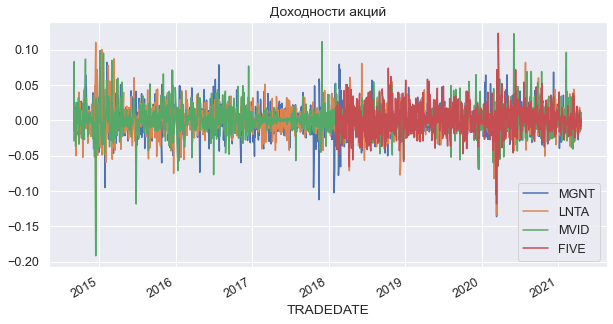

In [26]:
r.plot(figsize=(10, 5), title='Доходности акций');

Ряды имеют явно стационарный характер, спецификация для регрессии в тесте Дики-Фуллера - без константы и без тренда.

In [34]:
from statsmodels.tsa.stattools import adfuller
adf_res = {key: [] for key in ['ticker', 'p-value', 'ADF statistics', 
                              '1% critical value', '5% critical value', '10% critical value']}
for stock in r.columns:
    out = adfuller(r[stock].dropna().values.ravel())
    adf_res['ticker'].append(stock)
    adf_res['p-value'].append(round(out[1], 4))
    adf_res['ADF statistics'].append(round(out[0], 4))
    adf_res['1% critical value'].append(round(out[4]['1%'], 4))
    adf_res['5% critical value'].append(round(out[4]['5%'], 4))
    adf_res['10% critical value'].append(round(out[4]['10%'], 4))

adf_res = pd.DataFrame(adf_res)
adf_res

,ticker,p-value,ADF statistics,1% critical value,5% critical value,10% critical value
0,MGNT,0.0,-39.4918,-3.4343,-2.8633,-2.5677
1,LNTA,0.0,-39.0067,-3.4343,-2.8633,-2.5677
2,MVID,0.0,-38.0396,-3.4343,-2.8633,-2.5677
3,FIVE,0.0,-28.1673,-3.4385,-2.8651,-2.5687


In [36]:
adf_res.to_excel(fpath.replace('/images/', '/docs/')+'adf.xlsx')

Таким образом, нулевая гипотеза о наличии единичного корня отвергается на любом уровне значимости для всех доходностей, рассматриваемых в работе.

#### 5. Нарисуем ACF и PACF для моделей среднего.

In [39]:
def tsdisplay(y, figsize = (14,8), title = ""):
    
    tmp_data = pd.Series(y)
    
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = title, legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 30, zero = False, ax = fig.add_subplot(323))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 30, zero = False, ax = fig.add_subplot(324))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 50)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()

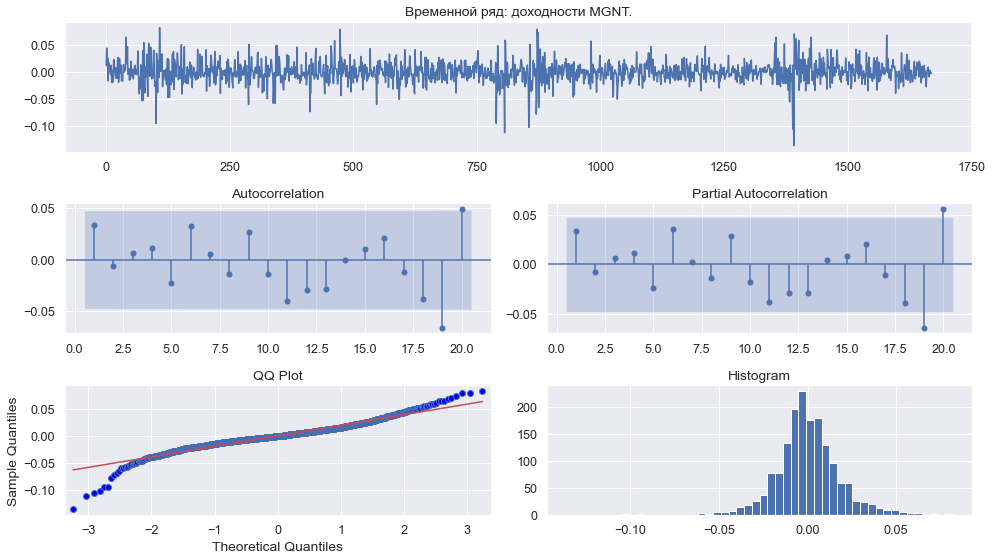

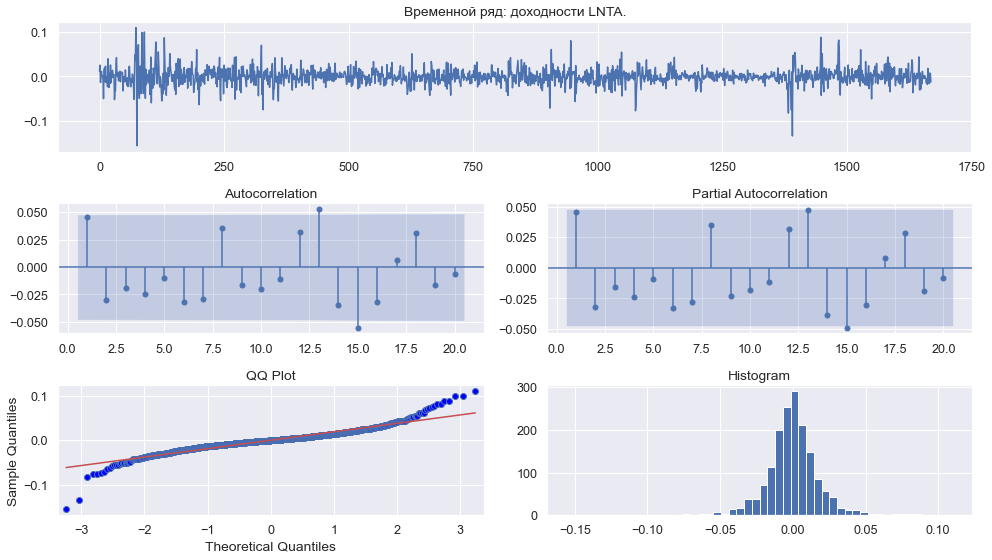

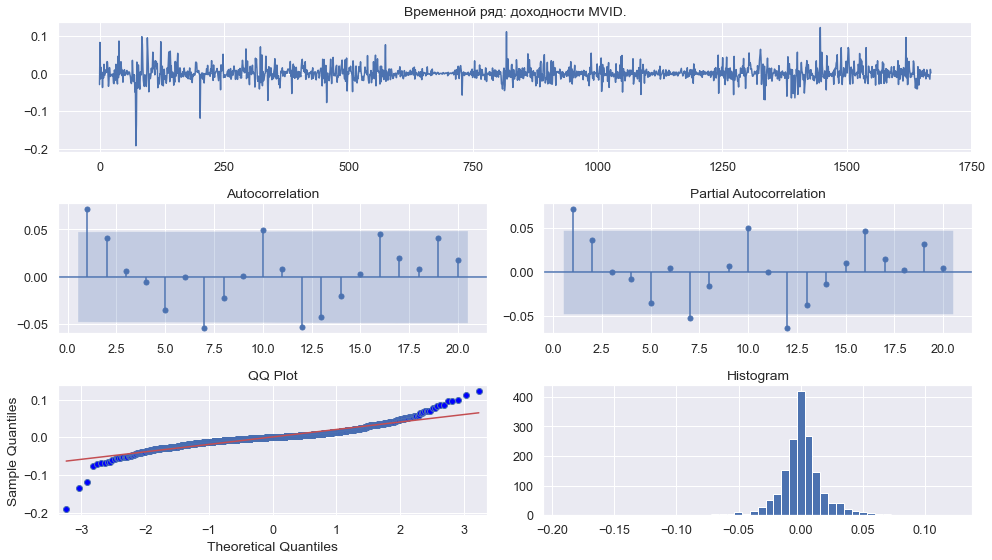

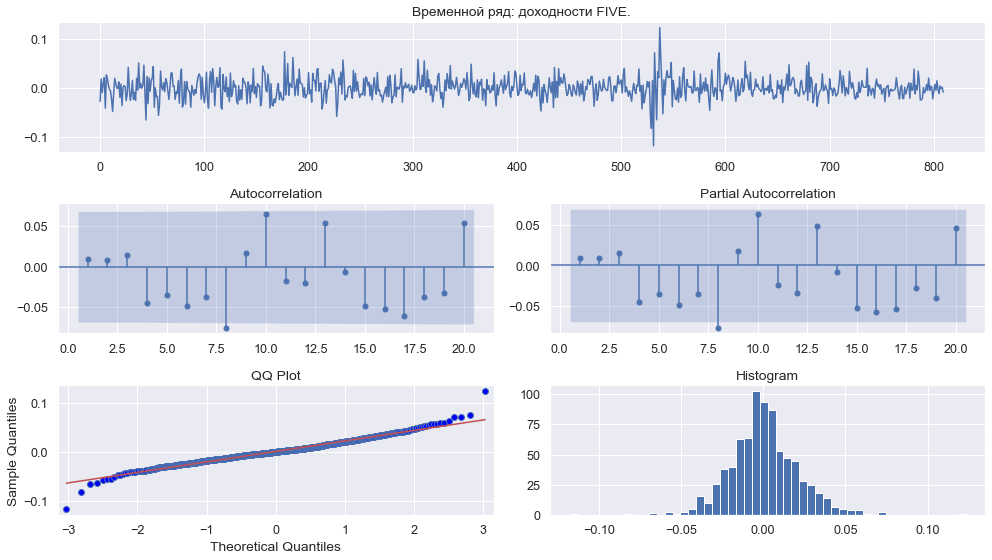

In [45]:
for stock in r.columns:
    tsdisplay(r[stock].dropna().values.squeeze(), title=f'Временной ряд: доходности {stock}.');
    plt.savefig(fpath+f'tsdisplay {stock}.jpg', dpi=1200, bbox_inches='tight');

Как ни удивительно, мы видим, что для всех акций занчимой автокорреляции в данных нет, и потому подходящая модель среднего для них - просто константа. Исключение составляет М.Видео, для которого имеет смысл рассмотреть модель среднего ARMA(1,1).

#### 6.  Теперь проверим автокорреляцию для квадратов остатков (то есть визуально оценим наличие гетероскедастичности).

Поскольку в среднем доходности всех инструментов близки к нулю, дисперсию доходностей можно оценить сверху как $\hat{Var}(return) = return^2$, поскольку 
$$
\mathrm{E[return_i]} \sim 0 \rightarrow 
\mathrm{Var[return_i]} = \mathrm{E[return_i^2]} - \big(\mathrm{E[return_i]} \big)^2 = 
\mathrm{E[return_i^2]} - 0 \sim return_i^2
$$

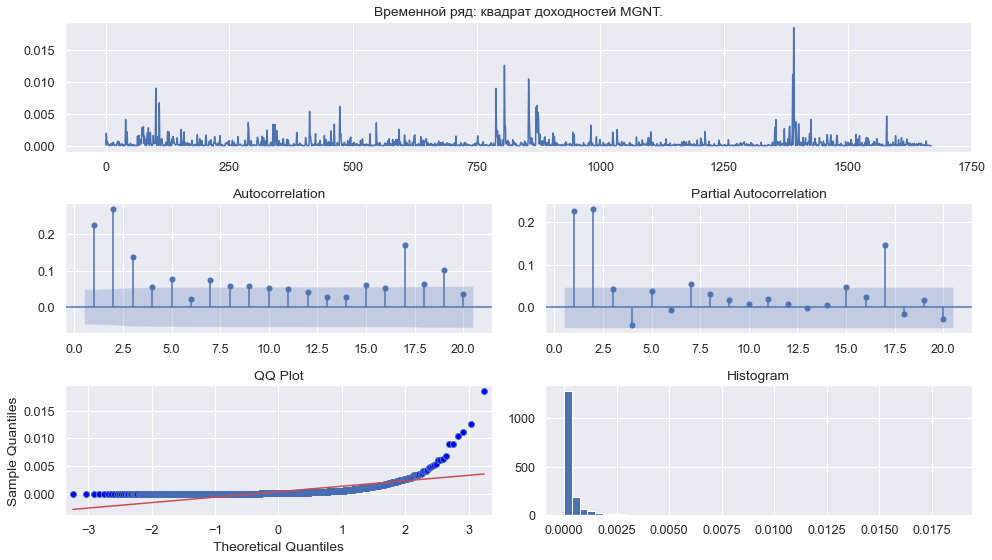

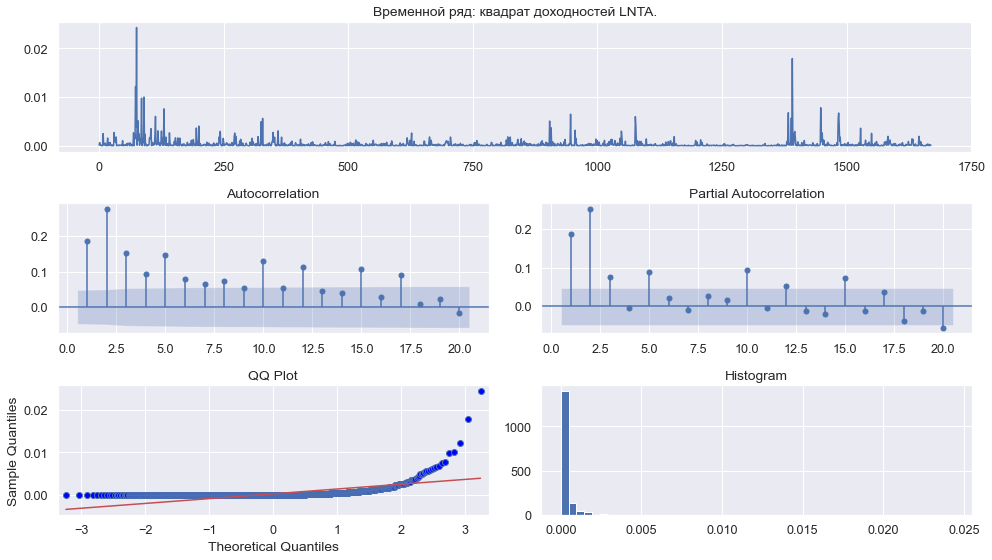

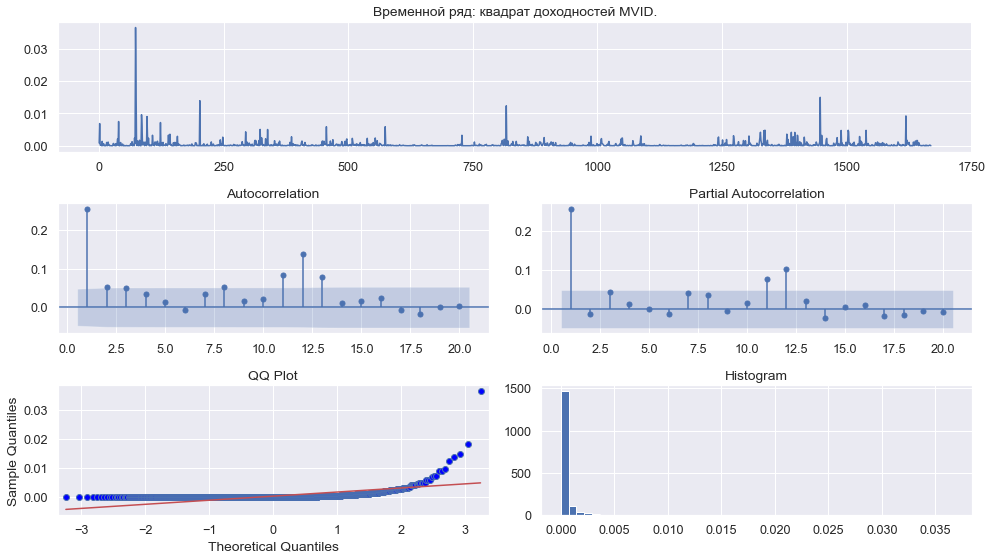

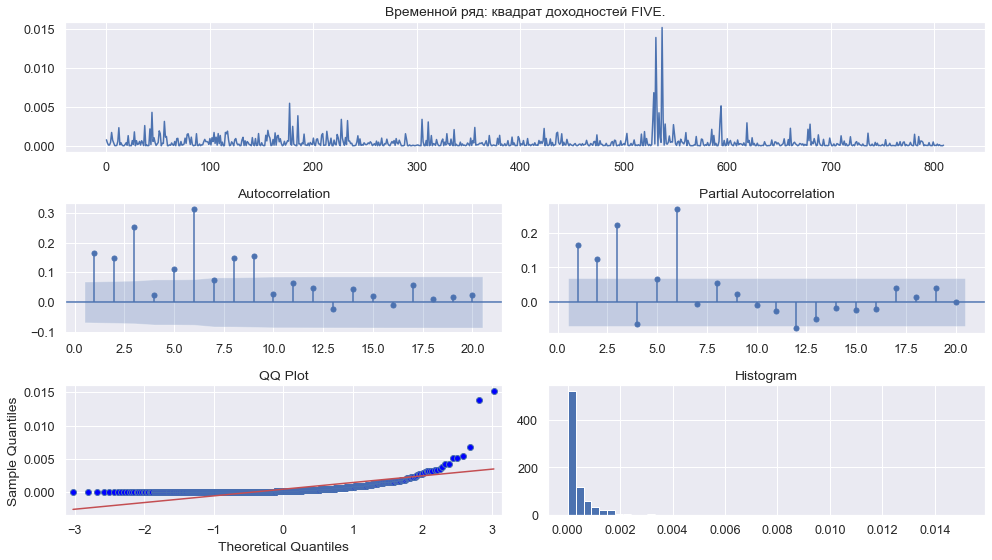

In [55]:
for stock in r.columns:
    tsdisplay((r[stock]**2).dropna().values.squeeze(), title=f'Временной ряд: квадрат доходностей {stock}.');
    plt.savefig(fpath+f'tsdisplay {stock} squared.jpg', dpi=1200, bbox_inches='tight');

У всех четырёх эмитентов наблюдается выраженная и значимая гетероскедастичность.

#### 7. Корреляционная матрица.

<AxesSubplot:>

Text(0.6, 1.07, 'Корреляция акций LNTA, MGNT, MVID, FIVE (2018-2021)')

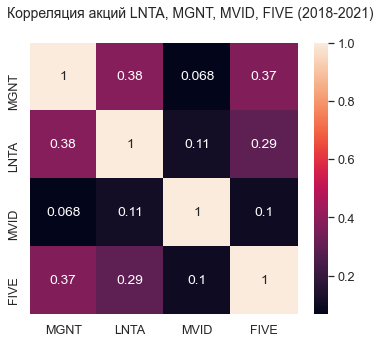

In [53]:
fig = plt.figure(figsize=(6, 5))
font = {'family':'normal',
            #'weight' : 'bold',
            'size': 14}
sns.heatmap(r['2018-02-02':].corr(), annot=True)
plt.title('Корреляция акций LNTA, MGNT, MVID, FIVE (2018-2021)', x=0.6, y=1.07, fontsize=14);
fig.savefig(fpath+'corrplot - FVIE.jpg', dpi=1200)

<AxesSubplot:>

Text(0.6, 1.07, 'Корреляция акций LNTA, MGNT, MVID (2014-2021)')

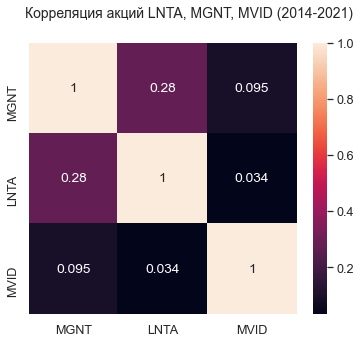

In [54]:
fig = plt.figure(figsize=(6, 5))
font = {'family':'normal',
            #'weight' : 'bold',
            'size': 14}
sns.heatmap(r.drop(columns=['FIVE']).corr(), annot=True)
plt.title('Корреляция акций LNTA, MGNT, MVID (2014-2021)', x=0.6, y=1.07, fontsize=14);
fig.savefig(fpath+'corrplot - no FIVE.jpg', dpi=1200)

Как и ожидалось, М.Видео гораздо менее коррелирован с остальными тремя акциями, чем те друг между другом.
**To do: посчитать скользящие характеристики!**